# Nedap Dev Day 2019 - Retail RFID Label Reading

## Problem Description

Suppose we scan a box with RFID labels for 30 seconds in an unclean environment. Create a machine learning model can read the box without including the rest of the environment.

## Machine Learning Pipeline

Below you can see a typical machine learning (ML) pipeline. In this hackathon, we already retrieved the data for you. Therefore, you you will work on the following parts:

* **Data preparation.** How can we transform the RFID readings in such a way that we can train a machine learning classifier to distinguish between labels inside/outside a box.
* **Modeling.** What is a suitable ML method to classify RFID readings.
* **Evaluation.** How well is the method working?



![Machine Learning Pipeline](ml-pipeline.png)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Description</a></span></li><li><span><a href="#Machine-Learning-Pipeline" data-toc-modified-id="Machine-Learning-Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Machine Learning Pipeline</a></span></li><li><span><a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Notebook Setup</a></span><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Utility Functions</a></span></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Load-Clean-EPC-Codes-(the-RFID-tag-labels-inside-the-box)" data-toc-modified-id="Load-Clean-EPC-Codes-(the-RFID-tag-labels-inside-the-box)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load Clean EPC Codes (the RFID tag labels inside the box)</a></span></li><li><span><a href="#Load-All-Samples" data-toc-modified-id="Load-All-Samples-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Load All Samples</a></span></li></ul></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train/Test Split</a></span></li><li><span><a href="#Baseline:-classify-each-EPC-code-as-outside-of-the-box" data-toc-modified-id="Baseline:-classify-each-EPC-code-as-outside-of-the-box-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Baseline: classify each EPC code as outside of the box</a></span></li><li><span><a href="#First-Machine-learning-classifier:-Logistic-Regression-with-two-Features" data-toc-modified-id="First-Machine-learning-classifier:-Logistic-Regression-with-two-Features-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>First Machine learning classifier: Logistic Regression with two Features</a></span><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Visualize-max(RSSI)-vs.-min(RSSI)" data-toc-modified-id="Visualize-max(RSSI)-vs.-min(RSSI)-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Visualize <code>max(RSSI)</code> vs. <code>min(RSSI)</code></a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Train/test-Logistic-Regression-Classifier" data-toc-modified-id="Train/test-Logistic-Regression-Classifier-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Train/test Logistic Regression Classifier</a></span></li></ul></li><li><span><a href="#Exercise-1:-Extract-additional-features" data-toc-modified-id="Exercise-1:-Extract-additional-features-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Exercise 1: Extract additional features</a></span><ul class="toc-item"><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Feature Extraction</a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Train/test-Logistic-Regression-Classifier" data-toc-modified-id="Train/test-Logistic-Regression-Classifier-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Train/test Logistic Regression Classifier</a></span></li></ul></li><li><span><a href="#Exercise-2:-Inspect-Feature-Importance" data-toc-modified-id="Exercise-2:-Inspect-Feature-Importance-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exercise 2: Inspect Feature Importance</a></span></li><li><span><a href="#Exercise-3:-different-classifiers" data-toc-modified-id="Exercise-3:-different-classifiers-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Exercise 3: different classifiers</a></span></li></ul></div>

## Notebook Setup

### Import Packages

In [1]:
import glob
from os.path import join, splitext
from pprint import pprint

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

### Utility Functions

In [2]:
import util

def evaluate(y_true, y_pred, class_names, cm_title='Confusion matrix, without normalization'):
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))
    util.plot_confusion_matrix(y_true, y_pred, classes=class_names, title=cm_title)

## Load Data

### Load Clean EPC Codes (the RFID tag labels inside the box)

In [3]:
clean_epcs = util.load_clean_epc_codes()

print('Number of clean EPCs: {}'.format(len(clean_epcs)))
pprint(clean_epcs)

Number of clean EPCs: 30
{'E28011700000020D350CAB2F',
 'E28011700000020D350CAB3F',
 'E28011700000020D350CABCF',
 'E28011700000020D350CABDF',
 'E28011700000020D350CABEF',
 'E28011700000020D350CABFF',
 'E28011700000020D350CC400',
 'E28011700000020D350CC58F',
 'E28011700000020D350CC59F',
 'E28011700000020D350CE1BE',
 'E28011700000020EC2506857',
 'E28011700000020EC2506956',
 'E28011700000020EC2506957',
 'E28011700000020EC250695C',
 'E28011700000020EC250695D',
 'E28011700000020EC2507056',
 'E28011700000020EC2507057',
 'E28011700000020EC250705C',
 'E28011700000020EC250705D',
 'E28011700000020EC250715C',
 'E2806894000040020364F48D',
 'E2806894000040020364F88D',
 'E28068940000400203650C8D',
 'E2806894000040020365148D',
 'E2806894000040020365188D',
 'E2806894000050020364F08D',
 'E2806894000050020364FC8D',
 'E2806894000050020365048D',
 'E2806894000050020365088D',
 'E2806894000050020365108D'}


### Load All Samples

In [4]:
df_samples = util.load_samples()
df_samples['in_box'] = df_samples.epc.isin(clean_epcs).astype(int)
df_samples.head()

,beam_id,epc,frequency,in_box,labelset_id,location_id,phase,rssi,sample_id,time
0,0,30347A12301D8FC59682FEFA,866900000,0,labelset3,samples_location1,15,-649,sample4,1.572351e+09
1,0,30347A12301D87C59682FF25,866900000,0,labelset3,samples_location1,55,-687,sample4,1.572351e+09
2,0,30347A12301D56459682FF93,866900000,0,labelset3,samples_location1,56,-754,sample4,1.572351e+09
3,0,30347A12301D6BC59682FF67,866900000,0,labelset3,samples_location1,14,-641,sample4,1.572351e+09
4,0,E28011700000020D350CABDF,866900000,1,labelset3,samples_location1,33,-762,sample4,1.572351e+09


## Train/Test Split

We split the data into train/test by `location_id`.

In [5]:
df_train = df_samples[df_samples.location_id == 'samples_location1'].copy()
df_test = df_samples[df_samples.location_id == 'samples_location2'].copy()

print('Samples train: {}'.format(len(df_train)))
print('Samples test: {}'.format(len(df_test)))

Samples train: 71271
Samples test: 76783


In [6]:
df_train.head(2)

,beam_id,epc,frequency,in_box,labelset_id,location_id,phase,rssi,sample_id,time
0,0,30347A12301D8FC59682FEFA,866900000,0,labelset3,samples_location1,15,-649,sample4,1.572351e+09
1,0,30347A12301D87C59682FF25,866900000,0,labelset3,samples_location1,55,-687,sample4,1.572351e+09


In [7]:
df_test.head(2)

,beam_id,epc,frequency,in_box,labelset_id,location_id,phase,rssi,sample_id,time
0,0,E28011700000020D350CABCF,866900000,1,labelset3,samples_location2,18,-687,sample4,1.572351e+09
1,0,E28011700000020D350CE1BE,866900000,1,labelset3,samples_location2,29,-609,sample4,1.572351e+09


## Baseline: classify each EPC code as outside of the box

Let's try a very basic classifier: classify each ECP code as outside of the box. 

We already get an accuracy of 96%. This tells us we should also look at recall and precision for both classes, which clearly is very low. We can do better than this with an machine learning model.

In [8]:
CLASS_NAMES = np.array(['Outside', 'Inside'])

              precision    recall  f1-score   support

     Outside     0.9621    1.0000    0.9807       762
      Inside     0.0000    0.0000    0.0000        30

    accuracy                         0.9621       792
   macro avg     0.4811    0.5000    0.4903       792
weighted avg     0.9257    0.9621    0.9435       792



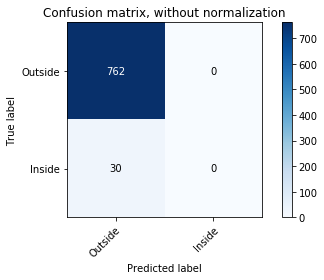

In [9]:
X_train = df_train.groupby('epc').count()
y_train = X_train.index.isin(clean_epcs).astype(int)

X_test = df_test.groupby('epc').count()
y_test = X_test.index.isin(clean_epcs).astype(int)


clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

evaluate(y_test, y_pred_test, class_names=CLASS_NAMES)

## First Machine learning classifier: Logistic Regression with two Features

### Feature Engineering

   * Feature engineering converts a real-live observation into a set of features (i.e., attributes) that characterizes an observation. 
   * For example, an RFID reading (observation) has a signal strength (feature).
   * We then ask the machine learning model to learn a mapping from the features of an observation to a decision 
   * Here: given the features of a reading, is it (A) inside the box or (B) outside the box?

Below we show how to compute two features: (1) The minimum RSSI (signal strength) and (2) the maximum RSSI for each RFID label.

In [10]:
def extract_features(df):
    agg = df.groupby('epc').agg(
        max_rssi=('rssi','max'),
        min_rssi=('rssi','min'),
    )
    
    return agg

Apply feature extractor to our data.

In [11]:
df_train_features = extract_features(df_train)

X_train = df_train_features.values
y_train = df_train_features.index.isin(clean_epcs).astype(int)

df_test_features = extract_features(df_test)

X_test = df_test_features.values
y_test = df_test_features.index.isin(clean_epcs).astype(int)

### Visualize `max(RSSI)` vs. `min(RSSI)`

We can see that a simple classifier with two features should already do reasonably well. 

In [12]:
c1 = df_train_features.iloc[np.where(y_train == 0)]
c2 = df_train_features.iloc[np.where(y_train == 1)]

Text(0, 0.5, 'min_rssi')

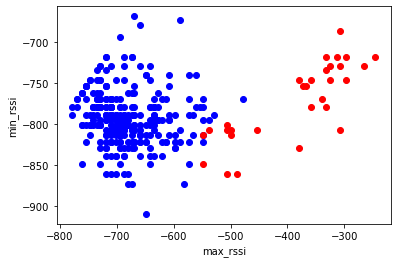

In [13]:
plt.scatter(c1['max_rssi'], c1['min_rssi'], c='b')
plt.scatter(c2['max_rssi'], c2['min_rssi'], c='r')
plt.xlabel('max_rssi')
plt.ylabel('min_rssi')

### Scaling

We first have to scale our data.

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### Train/test Logistic Regression Classifier

In [15]:
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

              precision    recall  f1-score   support

     Outside     0.9870    1.0000    0.9935       762
      Inside     1.0000    0.6667    0.8000        30

    accuracy                         0.9874       792
   macro avg     0.9935    0.8333    0.8967       792
weighted avg     0.9875    0.9874    0.9862       792



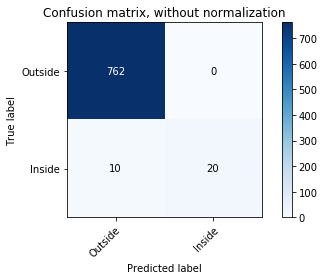

In [16]:
evaluate(y_test, y_pred_test, class_names=CLASS_NAMES)

## Exercise 1: Extract additional features

The classifier trained above used two features. Can we improve it by adding more features to it?

**Exercise 1:** design additional features that a machine learning model can use to classify RFID readings. Some inspiration: 
   * Number of readings for each EPC code?
   * Average signal strength
   * Median signal strength
   * 80th quantile
   * 20th quantile

Afterwards, run the code below and check how your model performs. How does this change if you remove some of the features?

Here is a list of functions that you may want to try:
https://pandas.pydata.org/pandas-docs/stable/reference/series.html#computations-descriptive-stats

### Feature Extraction

In [17]:
def extract_features(df):
    agg = df.groupby('epc').agg(
        max_rssi=('rssi','max'),
        min_rssi=('rssi','min'),
        # [Exericse] add your features here
    )
    
    return agg

extract_features(df_train)

,max_rssi,min_rssi
epc,,
30347A12301D51459682FF61,-649,-814
30347A12301D52459682FF65,-620,-795
30347A12301D52859682FF78,-598,-830
30347A12301D52C59682FF77,-747,-747
30347A12301D53059682FF76,-687,-719
...,...,...
E2806894000050020364F08D,-358,-779
E2806894000050020364FC8D,-313,-719
E2806894000050020365048D,-308,-807


In [18]:
df_train_features = extract_features(df_train)

X_train = df_train_features.values
y_train = df_train_features.index.isin(clean_epcs).astype(int)

df_test_features = extract_features(df_test)

X_test = df_test_features.values
y_test = df_test_features.index.isin(clean_epcs).astype(int)

### Scaling

We first have to scale our data.

In [19]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### Train/test Logistic Regression Classifier

In [20]:
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

              precision    recall  f1-score   support

     Outside     0.9870    1.0000    0.9935       762
      Inside     1.0000    0.6667    0.8000        30

    accuracy                         0.9874       792
   macro avg     0.9935    0.8333    0.8967       792
weighted avg     0.9875    0.9874    0.9862       792



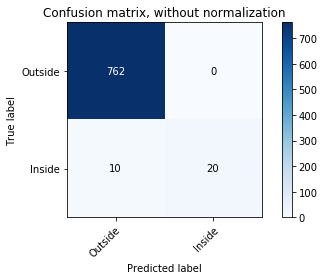

In [21]:
evaluate(y_test, y_pred_test, class_names=CLASS_NAMES)

## Exercise 2: Inspect Feature Importance

**Exercise:** What are the most important features for your classifier? What is the contribution of the features that you implemented?

In [22]:
eli5.show_weights(clf, feature_names=df_train_features.columns.values, target_names=CLASS_NAMES)

Weight?,Feature
+5.781,max_rssi
+0.158,min_rssi
-4.258,<BIAS>


## Exercise 3: different classifiers

scikit-learn offers a unified set of APIs to experiment with different classifiers. You have already seen how to use the `LogisticRegression` classifier above. 

**Exercise:** try different classifiers. Some suggestions:

* Decision Tree: https://scikit-learn.org/stable/modules/tree.html#classification
* k-nearest Neighbors (KNN): https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
* Support vector machine (SVM): https://scikit-learn.org/stable/modules/svm.html#classification

In [ ]:
# [Exercise] define your classifier here

# 1. Import classifier
# from sklearn. import ...

# 2. Instantiate classifier
clf = None # ...

# 3. Train it on the training data
clf.fit(X_train, y_train)

# 4. Make predictions on the test data
y_pred_test = clf.predict(X_test)

**Exercise:** Evaluate with the evaluation function below. How does the performance compare to the `LogisticRegression` classifier (see above)?

In [ ]:
# Evaluate the classifier you trained in the previous cell.

evaluate(y_test, y_pred_test, class_names=CLASS_NAMES)